In [2]:
import tensorflow as tf
from glob import glob
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

## Using the sharded TFRecords

In [3]:
config = {
    "model" : {
        "backend":              "./keras_yolov2/custom_backend.ResNet50CustomFeature",
        "input_size_w":         257,
        "input_size_h":         257,
        "gray_mode":            False,
        "anchors":              [0.14786,0.20233, 0.21790,0.38911, 0.23346,0.11673, 0.30739,0.19066, 0.47471,0.32296],
        #"anchors": (transformed, no longer divided by cell_w)             [1.33074, 1.68093, 2.34630, 1.22568, 2.48638, 2.13619, 3.11673, 4.16732, 5.53307, 2.27626],
        # gen anchors (no trans) "anchors":              [5.11111, 4.111111, 9.22222, 11.7777, 15.6666, 6.77777, 8.22222, 4.33333, 4.44444, 7.44444],
        # original "anchors":             [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
        "max_box_per_image":    10,        
        "labels":               ["dam"]
    },

    "parser_annotation_type":    "xml",

    "train": {
        "train_csv_file":       "",
        "train_csv_base_path":  "",
        "train_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_image_folder",
        "train_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/train_annot_folder",     

        "callback":             None,
        "train_times":          8,
        "pretrained_weights":   "",
        "batch_size":           16,
        "learning_rate":        0.0001,
        "nb_epochs":            40,
        "warmup_epochs":        3,

        "workers":              12,
        "max_queue_size":       40,
        "early_stop":           True,
        "tensorboard_log_dir":  "./logs/1",

        "object_scale":         5.0 ,
        "no_object_scale":      1.0,
        "coord_scale":          1.0,
        "class_scale":          1.0,

        "saved_weights_name":   "tiny_yolo_backend_best.h5",
        "debug":                False
    },

    "valid": {
        "iou_threshold":        "0.5",
        "score_threshold":      "0.5",
        "valid_csv_file":       "",
        "valid_csv_base_path":  "",
        "valid_image_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_image_folder",
        "valid_annot_folder":   "/vol/tensusers2/sdooper/dam_detection/keras_yolo2/valid_annot_folder",

        "valid_times":          1
    },

    "backup":{
        "create_backup":        False,
        "redirect_model":       True,
        "backup_path":          "../backup",
        "backup_prefix":        "Tiny_yolo_VOC"
    }
}

generator_config = {
    'IMAGE_H': 257,
    'IMAGE_W': 257,
    'IMAGE_C': 5,
    'GRID_H': 9,
    'GRID_W': 9,
    'BOX': 5,
    'LABELS': ["dam"],
    'CLASS': 1,
    'ANCHORS': [0.14786,0.20233, 0.21790,0.38911, 0.23346,0.11673, 0.30739,0.19066, 0.47471,0.32296],
    'BATCH_SIZE': 4,
    'TRUE_BOX_BUFFER': 50,
}

input_size = [257,257,5]

## The class from preprocessing.py, adjusted to multiple bboxes

In [11]:
import copy
import os
import xml.etree.ElementTree as et
import cv2
import numpy as np
from imgaug import augmenters as iaa
from imgaug.augmentables import BoundingBox, BoundingBoxesOnImage
from tqdm import tqdm
from glob import glob

from keras_yolov2.utils import BoundBox, bbox_iou

class BatchGenerator(object):
    def __init__(self, tfr_path, config, shuffle=True, jitter=True, norm=None, callback=None):
        
        # Path to the tfrecords
        self._tfr_path = tfr_path
        # config file
        self._config = config

        self._shuffle = shuffle
        self._jitter = jitter
        
        #obsolete parameter now?
        self._norm = norm
        #possible obsolete?
        self._callback = callback
    
        self._anchors = [BoundBox(0, 0, config['ANCHORS'][2 * i], config['ANCHORS'][2 * i + 1])
                         for i in range(int(len(config['ANCHORS']) // 2))]
        
        
        # augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        # All augmenters with per_channel=0.5 will sample one value _per image_
        # in 50% of all cases. In all other cases they will sample new values
        # _per channel_.
        self._aug_pipe = iaa.Sequential(
            [
                # apply the following augmenters to most images
                iaa.Fliplr(0.5),  # horizontally flip 50% of all images
                iaa.Flipud(0.2),  # vertically flip 20% of all images
                sometimes(iaa.Crop(percent=(0, 0.1))), # crop images by 0-10% of their height/width
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent
                    rotate=(-5, 5),  # rotate by -45 to +45 degrees
                    shear=(-5, 5),  # shear by -16 to +16 degrees
                    # order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    # cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    # mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                ))
            ],
            random_order=True
        )
    
        # Most likely obsolete
    def __len__(self):
        # 100: there are 100 examples per tfrecord in my specific example
        return int(np.ceil(float(len(self._tfr_path) * 100) / self._config['BATCH_SIZE']))
    
    # most likely obsolete
    def num_classes(self):
        return len(self._config['LABELS'])
    
    # most likely obsolete
    def size(self):
        return len(self._tfr_path) * 100
    
    
    def parse_serialized_example(self, example_proto):
        ''' Parser function
        Useful for functional extraction, i.e. .map functions

        Args:
            example_proto: a serialized example

        Returns:
            A dictionary with features, cast to float32
            This returns a dictionary of keys and tensors to which I apply the transformations.
        '''
        # feature columns of interest
        featuresDict = {
            'image/height': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/width': tf.io.FixedLenFeature(1, dtype=tf.int64),
            'image/filename': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/source_id': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/format': tf.io.FixedLenFeature(1, dtype=tf.string),
            'image/channel/B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
            'image/channel/B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
            'image/channel/B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
            'image/channel/AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
            'image/channel/NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            #'image/channel/AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            #'image/channel/AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/PIXEL_LABEL': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
            'image/channel/PIXEL_LABEL_CC': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),
            'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.int64), 
            'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.int64),
            'image/object/bbox/ymin': tf.io.VarLenFeature( dtype=tf.int64),
            'image/object/bbox/ymax': tf.io.VarLenFeature( dtype=tf.int64),
            'image/object/class/text': tf.io.VarLenFeature( dtype=tf.string),
            'image/object/class/label': tf.io.VarLenFeature( dtype=tf.int64)
        }

        return tf.io.parse_single_example(example_proto, featuresDict)
    def stretch_image_colorspace(self, img):
        max_val = tf.reduce_max(img)
        return tf.cast(tf.divide(img, max_val), tf.float32)
    
    def parse_features(self, features):
        rgb_chan = ['image/channel/' + x for x in ['B4', 'B3', 'B2']]
        
        mndwi_chan = [features[x] for x in ['image/channel/MNDWI']]
        img_chan = [features[x] for x in rgb_chan if x in rgb_chan]
        ave_chan = [features[x] for x in ['image/channel/AVE']]

        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)), perm=[1, 2, 0])
            
        # stretch color spaces of the RGB channels
        #if stretch_colorspace:
        img = self.stretch_image_colorspace(img)
        
        # MNDWI normalization
        mndwi_chan = tf.divide(tf.add(mndwi_chan, 1), 1 + 1)
        img = tf.concat([img, tf.transpose(mndwi_chan, perm=[1, 2, 0])], axis= 2)
        
        # AVE normalization
        ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
        img = tf.concat([img, tf.transpose(ave_chan, perm=[1, 2, 0])], axis= 2)
        # ===============
        # bounding box locations
        # ===============

    
        class_name = tf.sparse.to_dense(features['image/object/class/text'], default_value='0')

        obj = tf.stack([tf.sparse.to_dense(features['image/object/bbox/xmin']),
                        tf.sparse.to_dense(features['image/object/bbox/xmax']),
                        tf.sparse.to_dense(features['image/object/bbox/ymin']),
                        tf.sparse.to_dense(features['image/object/bbox/ymax'])
                        ], axis=1)

            
        # possibly redundant, but now for safe keeping, (attempt at deepcopying the variable)
        # orig_obj = tf.identity(obj)
        
        #image, all_objs = tf.numpy_function(self.aug_image,
        #                                    [img, obj, True],
        #                                    [tf.float32, tf.int64])
        
        # not actually a batch, just a single image
        x_batch, y_batch = tf.numpy_function(self.get_batch,
                                            [img, obj, self._config['ANCHORS'], class_name, True],
                                            [tf.float32, tf.float32])     
        
        return x_batch, y_batch
    
    def parse_features_annot(self, features):
        # Used during validation

        rgb_chan = ['image/channel/' + x for x in ['B4', 'B3', 'B2']]
        
        img_chan = [features[x] for x in rgb_chan if x in rgb_chan]
        ndwi_chan = [features[x] for x in ['image/channel/MNDWI']]
        ave_chan = [features[x] for x in ['image/channel/AVE']]

        
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)), perm=[1, 2, 0])
        
        # stretch color spaces of the RGB channels
        img = self.stretch_image_colorspace(img)
        
        # further normalization?
        img = tf.concat([img, tf.transpose(ndwi_chan, perm=[1, 2, 0])], axis= 2)
        
        ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
        img = tf.concat([img, tf.transpose(ave_chan, perm=[1, 2, 0])], axis= 2)
        
        # ===============
        # bounding box locations
        # ===============
        all_obj = tf.stack([tf.sparse.to_dense(features['image/object/bbox/xmin']),
                            tf.sparse.to_dense(features['image/object/bbox/xmax']),
                            tf.sparse.to_dense(features['image/object/bbox/ymin']),
                            tf.sparse.to_dense(features['image/object/bbox/ymax'])
                            ], axis=1)
        
        class_name = tf.sparse.to_dense(features['image/object/class/text'], default_value='0')    
    
        # Create and preprocess images and labels for network
        x_batch, y_batch = tf.numpy_function(self.get_batch,
                                            [img, all_obj, self._config['ANCHORS'], class_name, False],
                                            [tf.float32, tf.float32]) 
        
        return x_batch, all_obj, class_name
    
    
    # needs editing 
    def get_batch(self,img, objs, anchors, class_names, jitter=True):
        '''
            Args:
            
            self:
            
            img: the image in question, parsed through a tfrecord
            
            objs: same as image, but the labels
            
            anchor_pos, parsed through the tfrecord function
            
            jitter: image augmentations yes or no
        
        '''
        
        # 0 0 w h 
        all_anchors = [BoundBox(0, 0, anchors[2 * i], anchors[2 * i + 1])
                       for i in range(int(len(anchors) // 2))]
        # rewrite everything from batch level to single example
        #height width, channels from the image
        h, w, c = img.shape
        #code byte string to normal string
        #print(class_names)
        class_names =[x.decode('utf-8') for x in class_names]
        
        BOX = self._config['BOX']
        LABELS = len(self._config['LABELS'])
        
        # self.config['image width'], also height, and second line grid sizes for heigh and width , respect
        x_batch = np.zeros((self._config['IMAGE_H'], self._config['IMAGE_W'], c))  # input images
        y_batch = np.zeros((self._config['GRID_H'], self._config['GRID_W'], BOX, 4 + 1 + LABELS)) # desired network output       
        
        # augment input image and fix object's position and size
        img, all_objs = self.aug_image(img, objs, jitter= jitter)
        #print("before augment", objs)
        
        # this is a valid for loop (belongs to a single example)
        for class_idx, obj in enumerate(all_objs):
            #print(class_idx)
            # Translation list (dictionaries are not a good combo with tensorflow): 
            # 0: xmin  1: xmax 2: ymin  3: ymax
    
            # xmax > xmin and ymax > ymin and name and obj['name'] in self._config['LABELS']: (fix this later!!!)
            # center = 127 pixels, grid =8, width = 256, then center is at 127 / 32 ~= 3rd grid cell in x direction
            # OBJ NAME DOES NOT WORK
        
            #print(class_names[class_idx])
            #print(self._config['LABELS'])
            
            #print("obj", obj)
            #print("xmin < xmax?", obj[1] > obj[0])
            #print("ymin < ymax?", obj[3] > obj[2])
            #print("class names true?", class_names[class_idx] in self._config['LABELS'])
            
            if obj[1] > obj[0] and obj[3] > obj[2] and class_names[class_idx] in self._config['LABELS']:
                center_x = .5 * (obj[0] + obj[1])
                center_x = center_x / (float(self._config['IMAGE_W']) / self._config['GRID_W'] ) 
                center_y = .5 * (obj[2] + obj[3])
                center_y = center_y / (float(self._config['IMAGE_H']) / self._config['GRID_H']) 
                
                grid_x = int(np.floor(center_x))
                grid_y = int(np.floor(center_y))
    
                if grid_x < self._config['GRID_W'] and grid_y < self._config['GRID_H']:
                    # Alter the below variable later, not relevant yet
                    obj_indx = self._config['LABELS'].index(class_names[class_idx]) # DOES NOT WORK
                    # center relative to grid cell pixels:
                    # if center is 10 pixels and grid cell is 32 pixels: center_w=5/16, "width is 5/16th of grid cell" 
                    # 90 / (300/10) = 3
                    center_w = (obj[1] - obj[0]) / (
                                float(self._config['IMAGE_W']) / self._config['GRID_W'])
                    center_h = (obj[3] - obj[2]) / (
                                float(self._config['IMAGE_H']) / self._config['GRID_H'])
    
                    box = [center_x, center_y, center_w, center_h]
    
                    # find the anchor that best predicts this box
                    # i.e.: the best anchor shape that fits the box
                    best_anchor = -1
                    max_iou = -1
    
    
                    shifted_box = BoundBox(0, 0, center_w, center_h)
    
                    # fit anchors, which "shape" out of all anchors fits the current bbox best?
                    for i in range(len(all_anchors)):
                        anchor = all_anchors[i]
                        iou = bbox_iou(shifted_box, anchor)
    
                        if max_iou < iou:
                            best_anchor = i
                            max_iou = iou
    
                    # assign ground truth x, y, w, h, confidence and class probs to y_batch
                    y_batch[grid_y, grid_x, best_anchor, 0:4] = box
                    y_batch[grid_y, grid_x, best_anchor, 4] = 1.
                    y_batch[grid_y, grid_x, best_anchor, 5 + obj_indx] = 1
    
        # assign input image to x_batch
        norm = 1
        if norm is not None:
            x_batch = img
        # deal with this later? or done earlier in tfrecord procedure
        #if self._norm is not None:
        #   x_batch[instance_count] = self._norm(img)
        else:
            # plot image and bounding boxes for sanity check
            for obj in all_objs:
                if obj[1] > obj[0] and obj[3] > obj[2]:
                    cv2.rectangle(img[..., 0:3], (obj[0], obj[2]), (obj[1], obj[3]),
                                  (255, 0, 0), 3)
                    cv2.putText(img[..., ::-1], 'DAM', (obj[0] + 2, obj[2] + 12), 0,
                                1.2e-3 * img.shape[0], (0, 255, 0), 2)
    
            x_batch[instance_count] = img
    
        
        return x_batch, y_batch.astype(np.float32)
    
    def aug_image(self, image, objs, jitter=True):
        h = image.shape[0]
        w = image.shape[1]
        all_objs = copy.deepcopy(objs)
        
        if jitter:
            bbs = []
            for obj in all_objs:
                # see parse image for the correspondence between numeric index and values
                xmin = obj[0]
                xmax = obj[1] 
                ymin = obj[2]
                ymax = obj[3]            
                bbs.append(BoundingBox(x1=xmin, x2=xmax, y1=ymin, y2=ymax))           
            bbs = BoundingBoxesOnImage(bbs, shape=image.shape)
            image, bbs = self._aug_pipe(image=image, bounding_boxes=bbs)
            bbs = bbs.remove_out_of_image().clip_out_of_image()
    
            if len(all_objs) != 0:
                for i in range(len(bbs.bounding_boxes)):
                    all_objs[i][0] = bbs.bounding_boxes[i].x1 # xmin
                    all_objs[i][1] = bbs.bounding_boxes[i].x2 # xmax
                    all_objs[i][2] = bbs.bounding_boxes[i].y1 # ymin
                    all_objs[i][3] = bbs.bounding_boxes[i].y2 # ymax
                    
        # resize the image to standard size
        image = cv2.resize(image, (self._config['IMAGE_W'], self._config['IMAGE_H'])) 
        '''
        if self._config['IMAGE_C'] == 1: #self._config['IMAGE_C']
            image = image[..., np.newaxis]
        '''    
        #image = image[..., ::-1]  
        
        # fix object's position and size
        for obj in all_objs:
            for attr in [0, 1]: #xmin, xmax
                obj[attr] = int(obj[attr] * float(self._config['IMAGE_W']) / w) 
                obj[attr] = max(min(obj[attr], self._config['IMAGE_W']), 0)
    
            for attr in [2, 3]: #ymin, ymax
                obj[attr] = int(obj[attr] * float(self._config['IMAGE_H']) / h) 
                obj[attr] = max(min(obj[attr], self._config['IMAGE_H']), 0)
        return image, all_objs
    
    
    def __call__(self, mode):
        if mode is None:
            mode= 'train'
            batch_size = self._config['BATCH_SIZE']
            
        dataset = tf.data.TFRecordDataset(self._tfr_path, compression_type='GZIP')
        dataset = dataset.map(self.parse_serialized_example)
        dataset = dataset.apply(tf.data.experimental.ignore_errors())
        
        if mode == 'train':
            batch_size = self._config['BATCH_SIZE']
            dataset = dataset.map(self.parse_features)
            dataset = dataset.shuffle(buffer_size=1000)
            dataset = dataset.batch(batch_size, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            return dataset
    
        elif mode == 'valid':
            batch_size = self._config['BATCH_SIZE']
            dataset = dataset.map(self.parse_features)
            dataset = dataset.batch(batch_size, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            return dataset
        
        elif mode == 'map':
            batch_size = 1
            dataset = dataset.map(self.parse_features_annot)
            dataset = dataset.shuffle(buffer_size=1000)
            dataset = dataset.batch(batch_size, drop_remainder=True)
            dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
            return dataset



## The load_annotation from map_eval.py
testing whether multiple bboxes are now correctly concatenated with the class names

In [12]:
def load_annotation(bbox, class_name, labels):
    bbox = np.squeeze(bbox.numpy())
    # always reshape bbox into a 2d array
    bbox = np.reshape(bbox, (-1,4))
    bbox_dim = bbox.shape
    bbox = np.ravel(bbox, order='F')
    
    class_name = np.squeeze(class_name.numpy(), axis=0)
    class_name = [x.decode("utf-8") for x in class_name]
    class_name = np.array([labels.index(x) for x in class_name]) # convert to integers

    
    all_objs = np.reshape( np.concatenate( (bbox, class_name) ), (bbox_dim[0], 5), order='F') 

    annots = []
    for obj in all_objs:
        annot = [obj[0], obj[2], obj[1], obj[3], obj[4]]
        annots += [annot]

    if len(annots) == 0:
        annots = [[]]

    #print("annotations xmin, ymin, xmax, ymax is: ", annots)
    return np.array(annots)


## Testing and output

In [18]:
data_files = glob('../datasets/bbox_data/train/*.gz')
data_files = np.sort(data_files)
print(data_files[0:1])

['../datasets/bbox_data/train/dam-data-000.gz']


In [20]:
A = BatchGenerator(data_files[0:1], generator_config)

dataset = A(mode='map')

for i,(x_batch, bbox, class_names) in enumerate(dataset.take(1)):
    #print(x_batch, y_batch)
    print(i)
    print("bbox", bbox)
    annotations = load_annotation(bbox, class_names, ['dam'])
    print("annotation", annotations)
    


0
bbox tf.Tensor([[[125 132 120 136]]], shape=(1, 1, 4), dtype=int64)
annotation [[125 120 132 136   0]]


## Some extra tests

plotting the images and labels, along with the bounding boxes
The code is somewhat double and repetitive, but this was the laziest way

tf.Tensor(
[[ 27  40  42  60]
 [124 133 122 135]], shape=(2, 4), dtype=int64)
0
tf.Tensor([[118 139 121 135]], shape=(1, 4), dtype=int64)
tf.Tensor([[124 132 119 138]], shape=(1, 4), dtype=int64)
tf.Tensor([[124 133 119 137]], shape=(1, 4), dtype=int64)
tf.Tensor([[120 135 124 132]], shape=(1, 4), dtype=int64)
tf.Tensor(
[[124 132 122 134]
 [ 12  26 200 207]
 [ 70  84 217 228]], shape=(3, 4), dtype=int64)
tf.Tensor([[111 145 118 139]], shape=(1, 4), dtype=int64)
tf.Tensor(
[[167 173 124 151]
 [120 136 125 131]], shape=(2, 4), dtype=int64)
tf.Tensor([[107 149 121 135]], shape=(1, 4), dtype=int64)
tf.Tensor(
[[153 164 101 111]
 [124 132 123 132]
 [175 189 147 160]
 [149 165 174 182]
 [177 192 194 201]], shape=(5, 4), dtype=int64)
nr objects 5
labeled [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


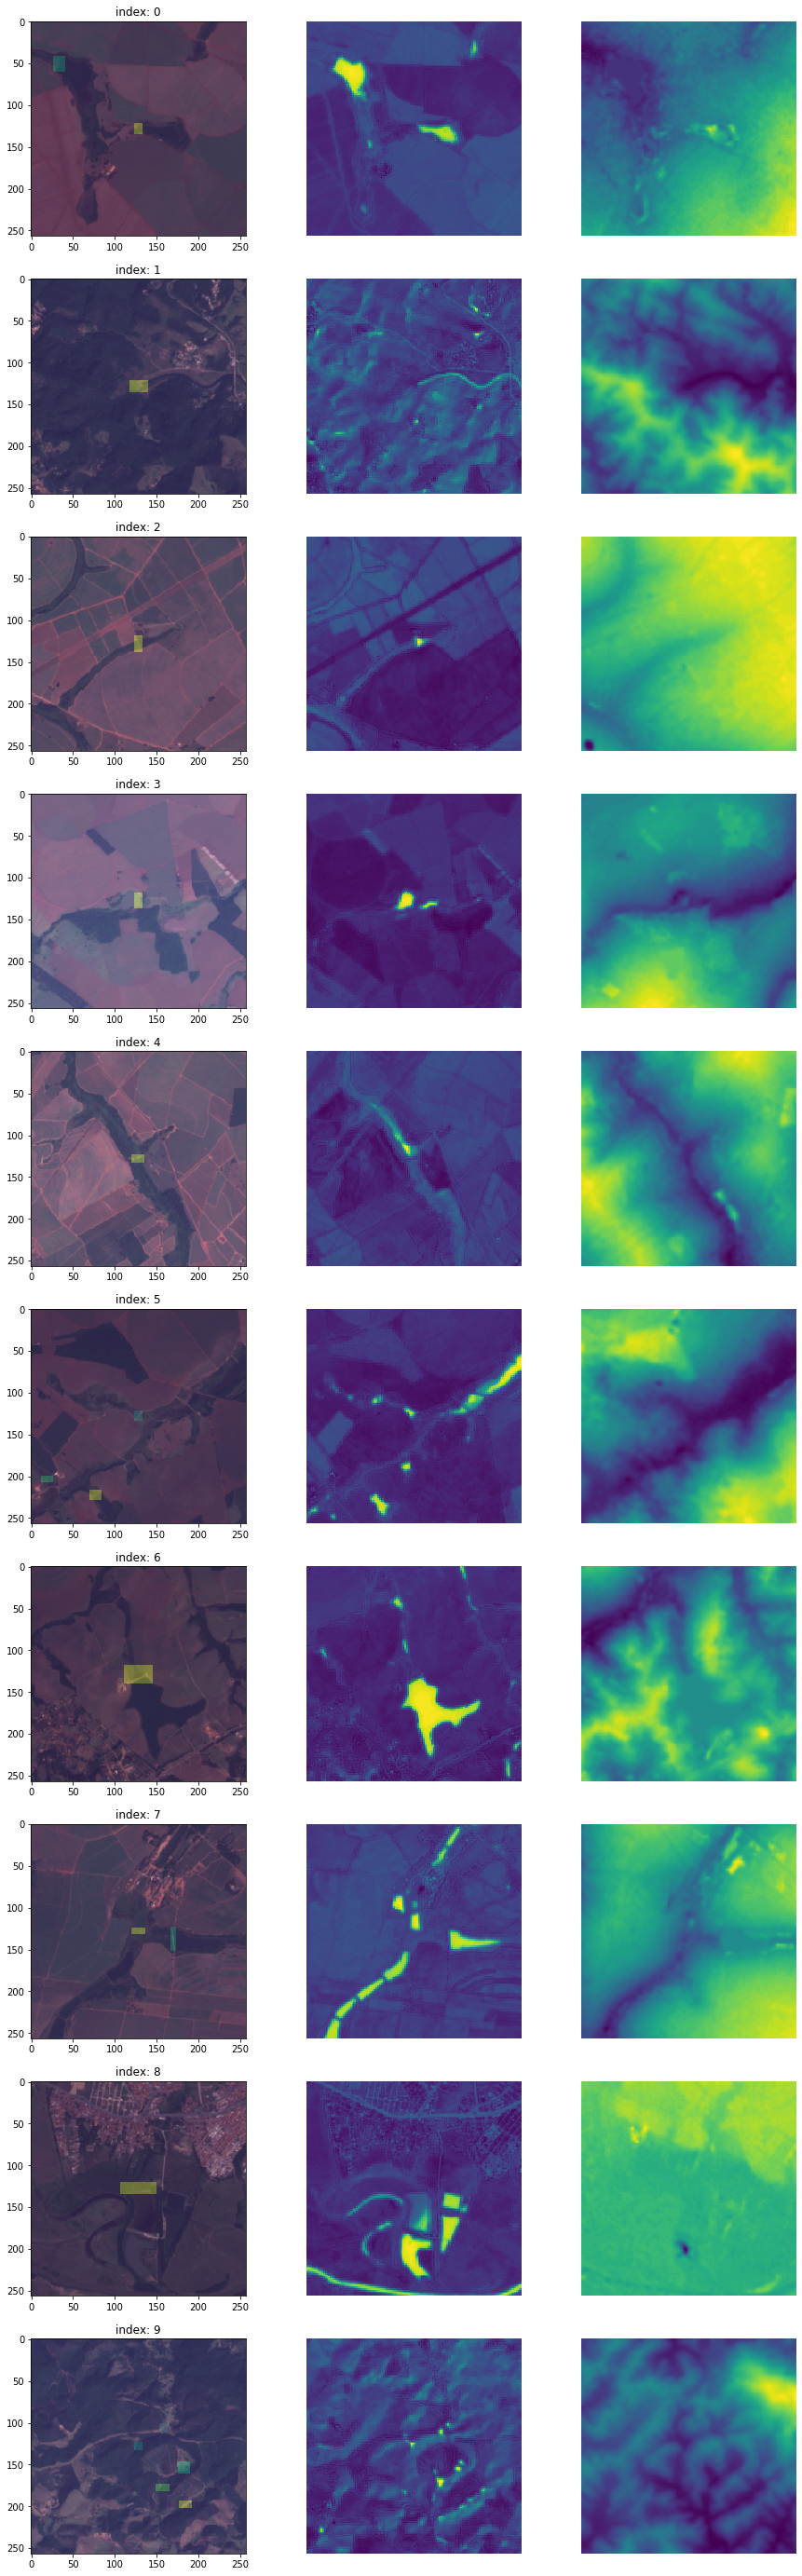

ymin 101
ymax 111
xmin 153
xmax 164
[153] [164] [101] [111]
ymin 123
ymax 132
xmin 124
xmax 132
[153, 124] [164, 132] [101, 123] [111, 132]
ymin 147
ymax 160
xmin 175
xmax 189
[153, 124, 175] [164, 132, 189] [101, 123, 147] [111, 132, 160]
ymin 174
ymax 182
xmin 149
xmax 165
[153, 124, 175, 149] [164, 132, 189, 165] [101, 123, 147, 174] [111, 132, 160, 182]
ymin 194
ymax 201
xmin 177
xmax 192
[153, 124, 175, 149, 177] [164, 132, 189, 165, 192] [101, 123, 147, 174, 194] [111, 132, 160, 182, 201]


In [133]:
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions

    Args:
        example_proto: a serialized example

    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'image/height': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/width': tf.io.FixedLenFeature(1, dtype=tf.int64),
        'image/filename': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/source_id': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/format': tf.io.FixedLenFeature(1, dtype=tf.string),
        'image/channel/B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'image/channel/B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'image/channel/B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'image/channel/AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'image/channel/NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        #'image/channel/AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        #'image/channel/AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/PIXEL_LABEL': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/channel/PIXEL_LABEL_CC': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # water index
        'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.int64), 
        'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.int64),
        'image/object/bbox/ymin': tf.io.VarLenFeature( dtype=tf.int64),
        'image/object/bbox/ymax': tf.io.VarLenFeature( dtype=tf.int64),
        'image/object/class/text': tf.io.VarLenFeature( dtype=tf.string),
        'image/object/class/label': tf.io.VarLenFeature( dtype=tf.int64)
    }

    return tf.io.parse_single_example(example_proto, featuresDict)


def stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)

def parse_features(features):
    col_channel = [features[x] for x in ['image/channel/B4', 'image/channel/B3', 'image/channel/B2']]
    mndwi_chan = [features[x] for x in ['image/channel/MNDWI']]
    ave_chan = [features[x] for x in ['image/channel/AVE']]


    #obj = [xmin, xmax, ymin, ymax]
    #pixel_label = feature['PIXEL_LABEL']
    img = tf.transpose(tf.squeeze(tf.stack(col_channel)) , perm=[1, 2, 0])
    img = stretch_image_colorspace(img)


    # MNDWI normalization
    mndwi_chan = tf.divide(tf.add(mndwi_chan, 1), 1 + 1)
    img = tf.concat([img, tf.transpose(mndwi_chan, perm=[1,2,0])], axis= 2)

    # AVE normalization
    ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
    img = tf.concat([img, tf.transpose(ave_chan, perm=[1,2,0])], axis= 2)

    y = tf.stack([tf.sparse.to_dense(features['image/object/bbox/xmin']),
                  tf.sparse.to_dense(features['image/object/bbox/xmax']),
                  tf.sparse.to_dense(features['image/object/bbox/ymin']),
                  tf.sparse.to_dense(features['image/object/bbox/ymax'])
                 ], axis=1)
    
    classes = tf.sparse.to_dense(features['image/object/class/label'])
    text_labels = tf.sparse.to_dense(features['image/object/class/text'], default_value='0')
    pixel_label = tf.reverse(features['image/channel/PIXEL_LABEL_CC'],[0])
    return y, pixel_label, img 

dataset = tf.data.TFRecordDataset(data_files[0:1], compression_type='GZIP')
dataset = dataset.map(parse_serialized_example)
dataset = dataset.map(parse_features)


gt_boxes = []
objs = []
images = []
num_img = 10
for i, (obj, gt, img) in enumerate(dataset.take(num_img)):
    print(obj)
    images.append(img)
    gt_boxes.append(gt)
    objs.append(obj)
    #print(obj)
    if i% 100 == 0:
        print(i)

labeled, nr_objects = ndimage.label(gt.numpy()) 
print("nr objects", nr_objects)
print("labeled", labeled)

fig, axes = plt.subplots(num_img,3)
fig.set_figheight(50)
fig.set_figwidth(15)

for i in range(num_img):
    axes[i,0].set_title("index: {}".format(i))
    axes[i,0].imshow(gt_boxes[i])
    axes[i,0].imshow(images[i][:,:,0:3], alpha=0.7)
    #axes[i,0].axis('off')
    axes[i,1].imshow(images[i][:,:,3])
    axes[i,1].axis('off')
    axes[i,2].imshow(images[i][:,:,4])
    axes[i,2].axis('off')
    
plt.show()  

xmins = []
xmaxs = []
ymins = []
ymaxs = []
for i in range(nr_objects):
    condition = np.equal(labeled, i+1)
    locs = np.where(condition)
    print("ymin", locs[0][0])
    print("ymax", locs[0][-1])
    print("xmin", locs[1][0])
    print("xmax", locs[1][-1])
    
    xmins.append(locs[1][0].astype(np.int32))
    xmaxs.append(locs[1][-1].astype(np.int32))
    ymins.append(locs[0][0].astype(np.int32))
    ymaxs.append(locs[0][-1].astype(np.int32))    

    print(xmins, xmaxs, ymins, ymaxs)

## Bounding boxes overlayed on segments

In [23]:
import cv2
import matplotlib.patches as patches

In [24]:
class BoundingBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        xmin  = int((box.x - box.w/2) * img_shape[1])
        xmax  = int((box.x + box.w/2) * img_shape[1])
        ymin  = int((box.y - box.h/2) * img_shape[0])
        ymax  = int((box.y + box.h/2) * img_shape[0])        
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth='2'))
    return plt_boxes

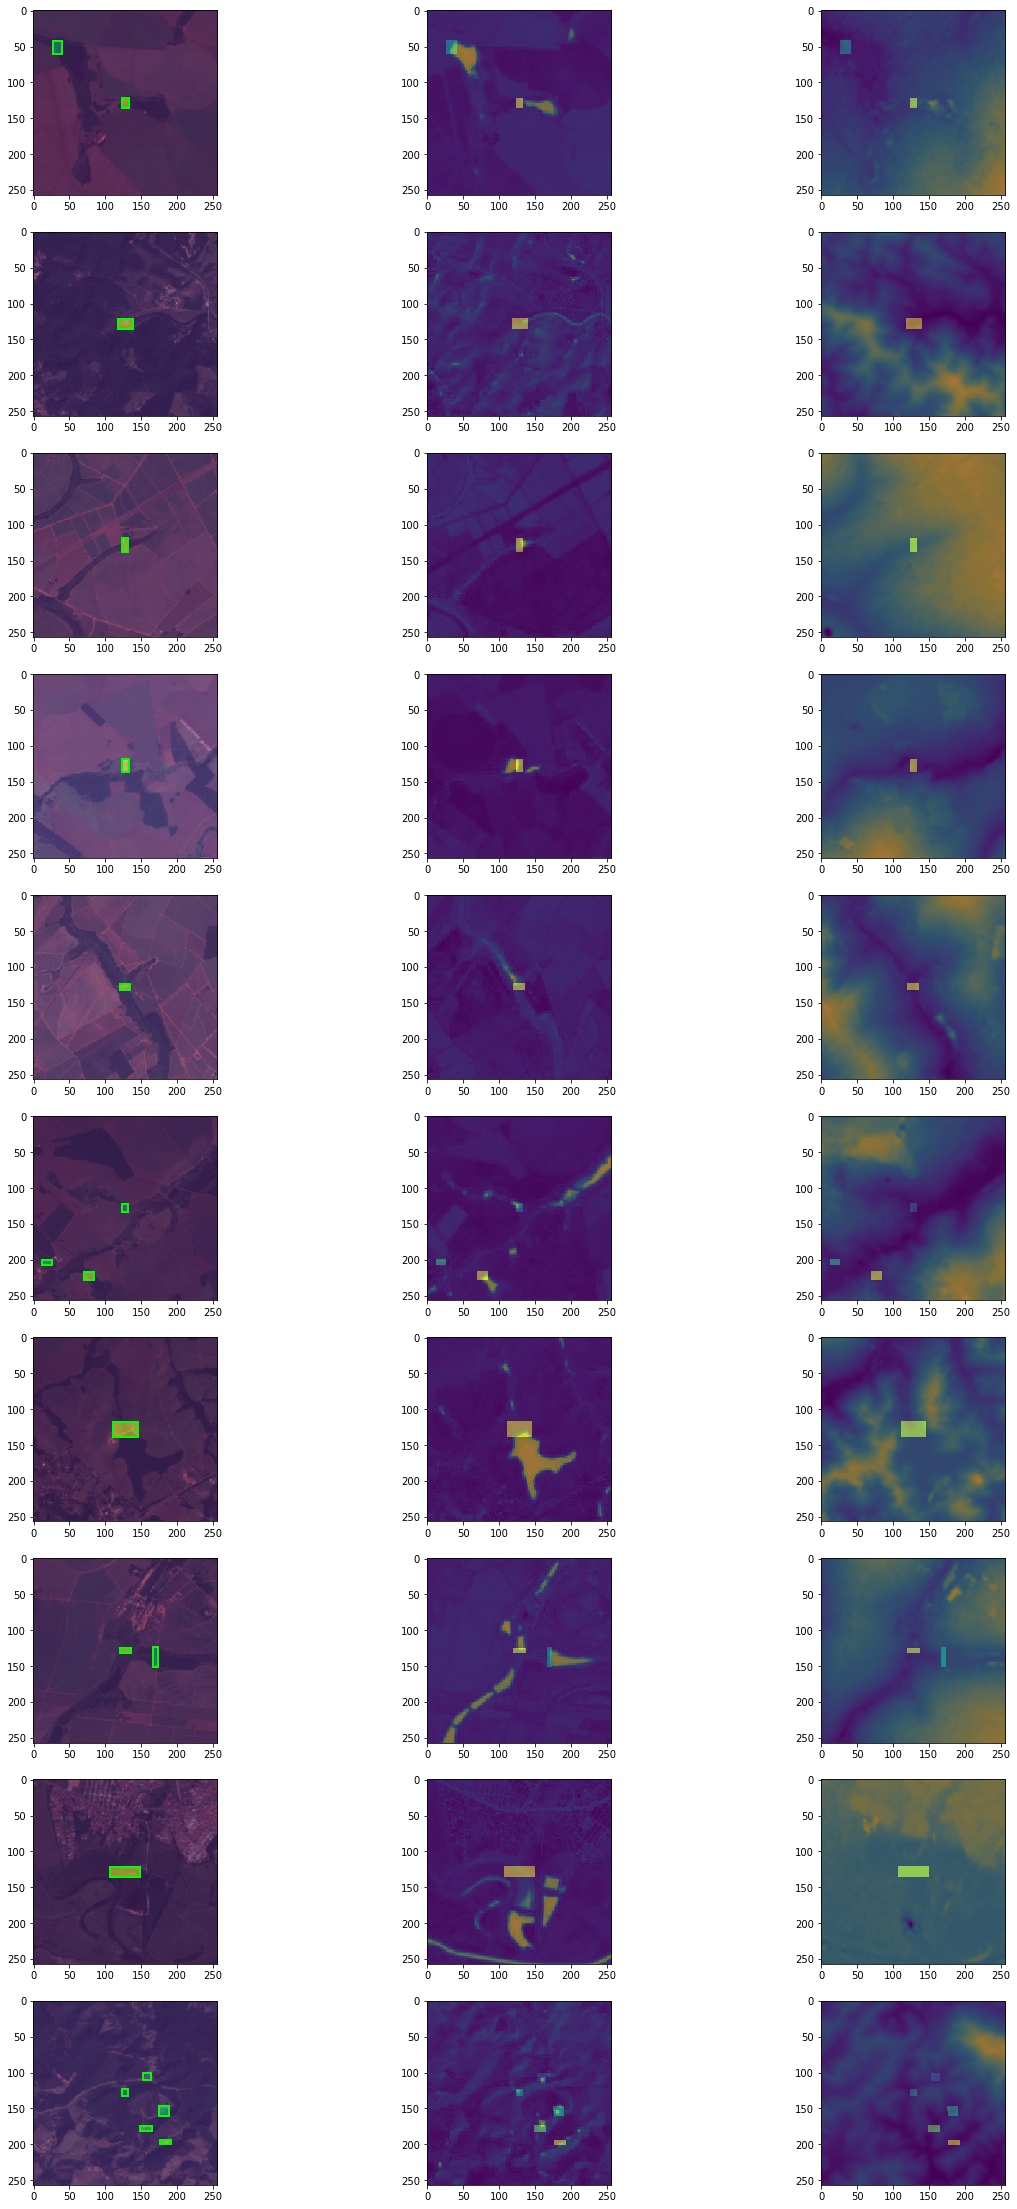

In [79]:
# plot image and bounding boxes for sanity check
num_img=10
fig, ax =  plt.subplots(num_img,3)
fig.set_figheight(40)
fig.set_figwidth(20)


for i in range(num_img):
    img = images[i][:,:,0:3].numpy()
    mndwi = images[i][:,:,3].numpy()
    ave = images[i][:,:,4].numpy()
    boxes = objs[i].numpy()
    boxes = [[(x2+x1)/2,(y2+y1)/2, x2-x1, y2-y1] for [x1,x2,y1,y2] in boxes/257]
    bbox = [BoundingBox(x, y, h, w) for [x,y,h,w] in boxes ]
    
    plt_boxes = get_matplotlib_boxes(bbox,img.shape)
    ax[i,0].imshow(img.squeeze(), cmap='binary')
    ax[i,0].imshow(gt_boxes[i], alpha=0.5)
    ax[i,1].imshow(mndwi)
    ax[i,1].imshow(gt_boxes[i], alpha=0.5)
    ax[i,2].imshow(ave)
    ax[i,2].imshow(gt_boxes[i], alpha=0.5)
    for plt_box in plt_boxes:
        ax[i,0].add_patch(plt_box)
        
        #plt.axis('off')      
plt.show()